# 🛒 Task 4: SQL for Data Analysis — E‑commerce Dataset (Sample)
This notebook performs SQL-style analysis on a UK online retail dataset. It uses a **10,000-row sample** (`data_sample.csv`). We use SQLite + Pandas to run SQL queries and include charts for insights.

**Dataset:** `data_sample.csv`.

In [3]:
from google.colab import files
uploaded = files.upload()


Saving data_sample.csv to data_sample.csv


In [4]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')
pd.set_option('display.max_columns', 50)

In [5]:
# Load and clean dataset (sample)
df = pd.read_csv("data_sample.csv", encoding="latin1")

# Clean column names
df.columns = [c.strip().replace(" ", "_") for c in df.columns]

# Parse dates
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], dayfirst=True, errors='coerce')

# Remove cancelled invoices (InvoiceNo starting with 'C')
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]

# Remove negative or zero Quantity/UnitPrice
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

# Create Revenue column
df['Revenue'] = df['Quantity'] * df['UnitPrice']

# Drop rows with missing CustomerID
df = df.dropna(subset=['CustomerID'])
df['CustomerID'] = df['CustomerID'].astype(int)

print("Rows after cleaning:", len(df))
df.head()

Rows after cleaning: 7323


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue
0,555200,71459,HANGING JAM JAR T-LIGHT HOLDER,24,2011-01-06 12:05:00,0.85,17315,United Kingdom,20.40
1,554974,21128,GOLD FISHING GNOME,4,NaT,6.95,14031,United Kingdom,27.80
2,550972,21086,SET/6 RED SPOTTY PAPER CUPS,4,NaT,0.65,14031,United Kingdom,2.60
3,576652,22812,PACK 3 BOXES CHRISTMAS PANETTONE,3,NaT,1.95,17198,United Kingdom,5.85
4,546157,22180,RETROSPOT LAMP,2,2011-10-03 08:40:00,9.95,13502,United Kingdom,19.90


In [6]:
# Push cleaned data into in-memory SQLite DB
conn = sqlite3.connect(":memory:")
df.to_sql('orders', conn, index=False, if_exists='replace')
print("Orders table rows:", pd.read_sql_query('SELECT COUNT(*) as cnt FROM orders', conn).iloc[0]['cnt'])

Orders table rows: 7323


In [7]:
# Top products by revenue
query = """
SELECT StockCode, Description, SUM(Revenue) AS total_revenue, SUM(Quantity) AS total_qty
FROM orders
GROUP BY StockCode, Description
ORDER BY total_revenue DESC
LIMIT 10;
"""
pd.read_sql_query(query, conn)

,StockCode,Description,total_revenue,total_qty
0,21175,GIN + TONIC DIET METAL SIGN,3629.39,2107
1,85099B,JUMBO BAG RED RETROSPOT,2931.50,1595
2,85099F,JUMBO BAG STRAWBERRY,1787.17,1049
3,22728,ALARM CLOCK BAKELIKE PINK,1709.25,499
4,22273,FELTCRAFT DOLL MOLLY,1706.15,737
5,47566,PARTY BUNTING,1576.55,351
6,22423,REGENCY CAKESTAND 3 TIER,1427.55,121
7,85123A,WHITE HANGING HEART T-LIGHT HOLDER,1166.15,417
8,22730,ALARM CLOCK BAKELIKE IVORY,1102.50,272
9,23135,SMALL ZINC HEART WALL ORGANISER,1055.76,318


In [8]:
# Top customers by revenue
query = """
SELECT CustomerID, COUNT(DISTINCT InvoiceNo) AS orders_count, SUM(Revenue) AS total_revenue
FROM orders
GROUP BY CustomerID
ORDER BY total_revenue DESC
LIMIT 10;
"""
pd.read_sql_query(query, conn)

,CustomerID,orders_count,total_revenue
0,14646,23,4887.33
1,15749,1,3380.00
2,14156,18,2976.13
3,14911,81,2736.38
4,15769,5,2433.88
5,17450,7,2369.72
6,18102,6,2282.51
7,15838,1,1790.00
8,16029,3,1760.04
9,14680,7,1601.64


In [9]:
# Revenue by country
query = """
SELECT Country, SUM(Revenue) AS total_revenue
FROM orders
GROUP BY Country
ORDER BY total_revenue DESC
LIMIT 15;
"""
rev_country = pd.read_sql_query(query, conn)
rev_country

,Country,total_revenue
0,United Kingdom,125169.90
1,EIRE,5765.07
2,Netherlands,4975.25
3,Germany,4356.67
4,France,3891.04
5,Australia,1676.48
6,Spain,891.70
7,Norway,872.38
8,Switzerland,698.37
9,Portugal,695.25


In [10]:
# Monthly revenue trend
query = """
SELECT strftime('%Y-%m', InvoiceDate) AS month, SUM(Revenue) AS total_revenue, COUNT(DISTINCT InvoiceNo) AS order_count
FROM orders
GROUP BY month
ORDER BY month;
"""
monthly = pd.read_sql_query(query, conn)
monthly['month'] = pd.to_datetime(monthly['month'])
monthly

,month,total_revenue,order_count
0,NaT,90297.57,2991
1,2010-01-01,656.77,29
2,2010-02-01,981.82,25
3,2010-03-01,116.05,11
4,2010-05-01,411.69,30
5,2010-06-01,845.63,35
6,2010-07-01,403.22,15
7,2010-08-01,657.14,26
8,2010-09-01,502.85,25
9,2010-10-01,696.76,16


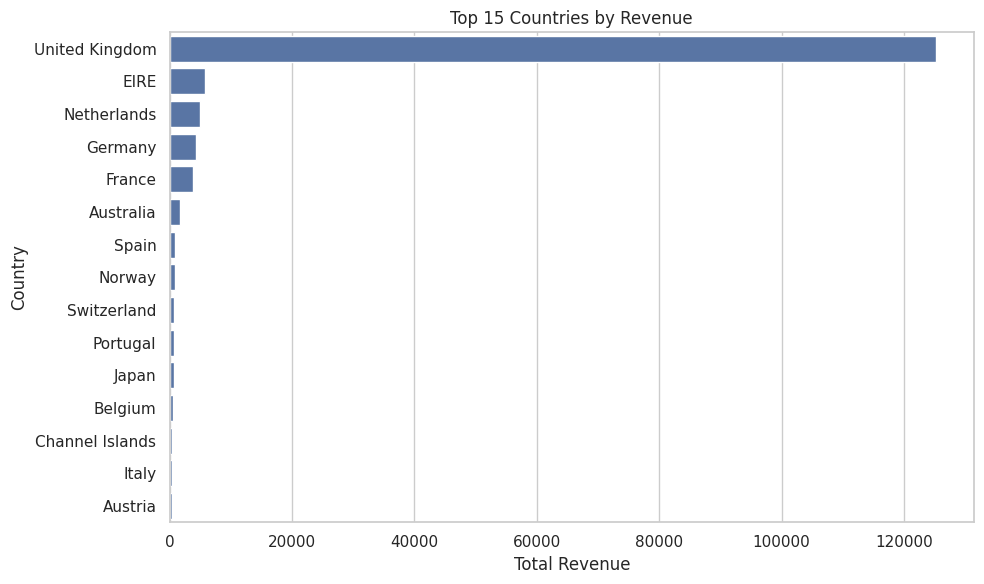

In [11]:
# Chart: Revenue by Country
plt.figure(figsize=(10,6))
ax = sns.barplot(data=rev_country, x='total_revenue', y='Country')
ax.set_title('Top 15 Countries by Revenue')
ax.set_xlabel('Total Revenue')
plt.tight_layout()
plt.show()

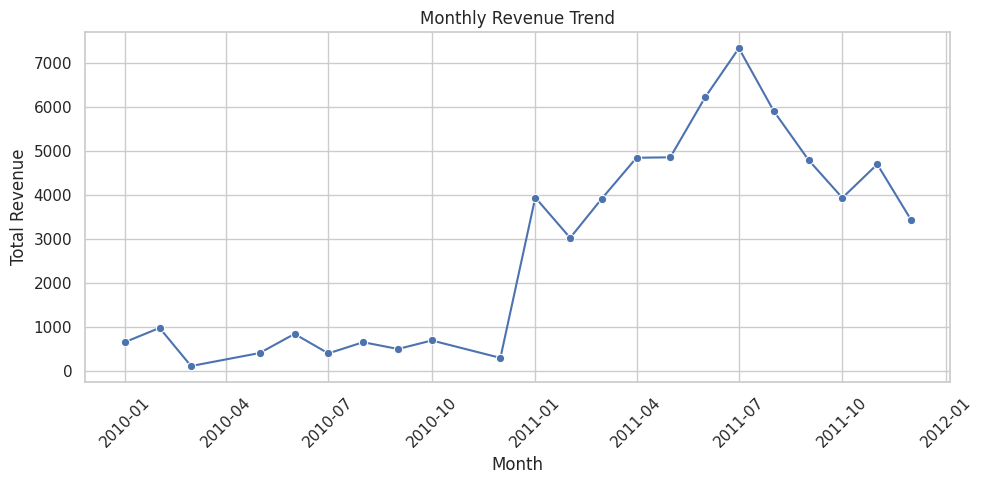

In [12]:
# Chart: Monthly Revenue Trend
plt.figure(figsize=(10,5))
ax = sns.lineplot(data=monthly, x='month', y='total_revenue', marker='o')
ax.set_title('Monthly Revenue Trend')
ax.set_xlabel('Month')
ax.set_ylabel('Total Revenue')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 🔍 Observations
- The UK dominates revenue, but there are international orders as well.  
- Top products contribute significantly to revenue concentration.  
- Some customers generate disproportionately high revenue.  
- Revenue shows seasonal spikes around holidays.  
- Data cleaning was essential: cancelled invoices, negative values, and missing IDs were removed.  


## ✅ Outcome
This analysis demonstrates SQL for Data Analysis combined with visualization.  
We practiced:
- Data cleaning and preparation  
- SQL queries inside Python with SQLite  
- GROUP BY, ORDER BY, Aggregations  
- Trend analysis with charts  

This mirrors real-world data analyst workflows for ecommerce businesses.  
